# Imports

In [1]:
print("Loading imports...")
import numpy as np
import dedalus.public as d3
import logging
import os
import time

import xarray as xr
from glob import glob

import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = plt.cm.RdBu_r
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator
from matplotlib.gridspec import GridSpec
print("Imports loaded")

Loading imports...
2024-03-05 16:47:36,686 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2024-03-05 16:47:36,696 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2024-03-05 16:47:37,559 numexpr.utils 0/1 INFO :: Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-05 16:47:37,561 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.
Imports loaded


# Problem Setup

In [37]:
logger = logging.getLogger(__name__)

# Simulation units
# meter = 1 / 6.37122e6
meter = 1
# hour = 1
# second = hour / 3600
second = 1
hour = 3600 * second
day = 24 * hour
kilogram = 1
Kelvin = 1
Joule = kilogram * meter**2 / second**2

# Parameters
Nphi = 8
Ntheta = 32
dealias = 3/2
EARTH_RADIUS = 6.37122e6 * meter
Omega = 7.292e-5 / second

GRAVITY = 9.80616 * meter / second**2                          # g [m/s^2]
EQUIVALENT_DEPTH = 250. * meter                                # H [m]
CORIOLIS_PARAMETER = 2.29e-11 / meter / second                 # ß [m^-1 s^-1]
AIR_DENSITY = 1.225 * kilogram / meter**3                      # ρ_a [kg m^-3]
WATER_DENSITY = 997 * kilogram / meter**3                      # ρ_w [kg m^-3]
LATENT_HEAT = 2260000 * Joule / kilogram / Kelvin              # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004 * Joule / kilogram                        # c_p [J kg^-1]
GROSS_DRY_STABILITY = 3.12e4 * Kelvin * kilogram / meter**2    # M_s [K kg m^-2]
CLOUD_RADIATIVE_PARAMETER = 0.2
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)  
gross_moisture_stratification = 0.75*GROSS_DRY_STABILITY       # M_q [K kg m^-2]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)  # L [m]
METERS_PER_RADIAN = 2*np.pi*EARTH_RADIUS/(2*np.pi)
length_scale /= METERS_PER_RADIAN

sigma_x = 5e-4
sigma_y = 9e-9

epst = 1/(2 * hour)
epsq = 1/(6 * hour)

timestep = 600 * second
# simulation_length = 360 * hour
# simulation_length = 360 * day
simulation_length = 120 * day
dtype = np.float64

print(f"{'Problem Parameters':^50}")
print(f"{'':{'='}^{50}}")
print(f"{EARTH_RADIUS = :>35.2e}")
print(f"{Omega = :>42.2e}")
print(f"{epst = :43.2e}")
print(f"{epsq = :43.2e}")
print(f"{timestep = :39.2e}")
print(f"{'':{'='}^{50}}")

total_iterations = simulation_length//timestep
n_chunks = 12
max_writes = total_iterations//n_chunks
downsample_interval = 1 * hour
log_interval = 6 * day

max_logs = 100
num_logs = int(simulation_length/log_interval)
if num_logs > max_logs:
    print(f"Log interval ({log_interval/hour} hour) creates too many logs ({num_logs}), capping number of logs at {max_logs}")
    log_interval = int(simulation_length / max_logs)
    num_logs = max_logs
else:
    print(f"Log interval = {log_interval/hour} hour(s), number of logs = {num_logs:0.0f}")

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=EARTH_RADIUS, dealias=dealias, dtype=dtype)
e_phi = dist.VectorField(coords, bases=basis)
e_theta = dist.VectorField(coords, bases=basis)
e_phi['g'][0] = 1
e_theta['g'][1] = 1

cartesian_coords = d3.CartesianCoordinates('x', 'y')
cartesian_dist = d3.Distributor(cartesian_coords, dtype=dtype)

# Fields
s = dist.Field(name = 's')
u = dist.VectorField(coords, name='u', bases=basis)
T = dist.Field(name='T', bases=basis)
q = dist.Field(name='q', bases=basis)

# Substitutions
zcross = lambda A: d3.MulCosine(d3.skew(A))

# Initial conditions: zonal jet
phi, theta = dist.local_grids(basis)

u['g'][0] = gravity_wave_phase_speed * np.cos(phi) * np.exp(-((theta-np.pi/2)/length_scale)**2)
T['g'] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2) * gravity_wave_phase_speed * np.cos(phi) * np.exp(-((theta-np.pi/2)/length_scale)**2)
q['g'] = -(gross_moisture_stratification/gravity_wave_phase_speed**2) * gravity_wave_phase_speed * np.cos(phi) * np.exp(-((theta-np.pi/2)/length_scale)**2)

# latitude = np.pi / 2 - theta
# ncc_theta = dist.Field(bases=basis)
# # ncc_theta['g'] = np.sin(theta)
# ncc_theta['g'] = -EARTH_RADIUS*(theta-np.pi/2)

# latitude = np.pi / 2 - theta
# ncc_theta = dist.Field(bases=basis)
# ncc_theta['g'] = EARTH_RADIUS*(theta-np.pi/2)
# ncc_theta['g'][:, np.where(np.abs(180*latitude.squeeze()/np.pi) >= 30)] = 0

ncc_theta = dist.Field(bases=basis)
ncc_theta['g'] = np.sin(theta.squeeze())

                Problem Parameters                
EARTH_RADIUS =                            6.37e+06
Omega =                                   7.29e-05
epst =                                    1.39e-04
epsq =                                    4.63e-05
timestep =                                6.00e+02
Log interval = 144.0 hour(s), number of logs = 20


# Plot initial condition

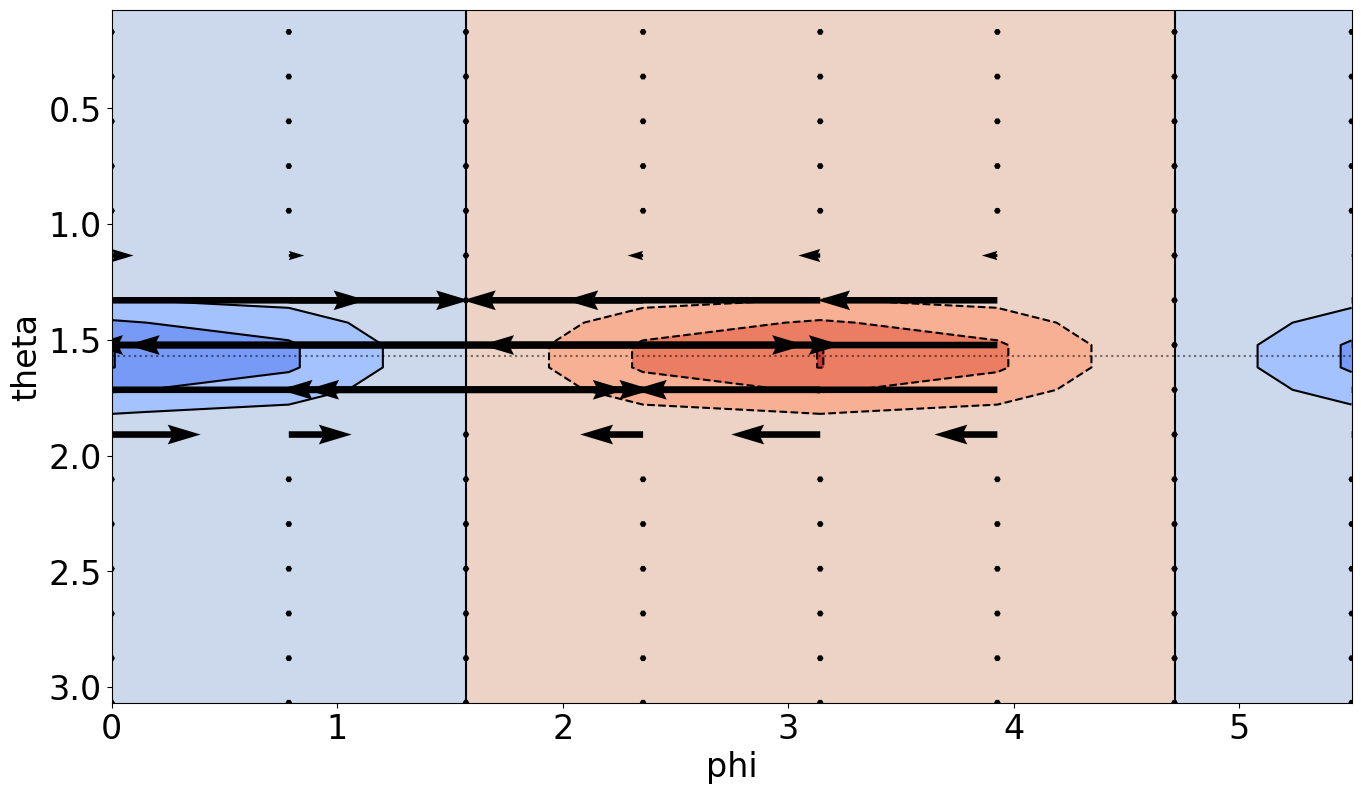

In [3]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
plt.figure(figsize=(16,9))
plt.contourf(
    phi.squeeze(),
    theta.squeeze(),
    q['g'].T, 
    cmap='coolwarm',
)

plt.contour(
    phi.squeeze(),
    theta.squeeze(),
    T['g'].T, 
    colors='k',
)

plt.quiver(
    phi.squeeze()[::1], 
    theta.squeeze()[::2], 
    u['g'][0][::1, ::2].T, 
    u['g'][1][::1, ::2].T,
)

plt.gca().invert_yaxis()
plt.axhline(y=np.pi/2, ls=':', color='k', alpha=0.5)
plt.xlabel('phi')
plt.ylabel('theta')
# plt.gca().set_aspect('equal')
plt.show()

# Build IVP solver

In [45]:
# Problem
problem = d3.EVP([u, T], eigenvalue=s, namespace=locals())
# problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
# problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = - div(h*u)")

# problem.add_equation("dt(u) + g*grad(h) = - 2*Omega*ncc_theta*zcross(u)")
# problem.add_equation("dt(h) + H*div(u) + eps*h= 0")
dt = lambda A: s*A

problem.add_equation("dt(u) + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*grad(T) + 2*Omega*zcross(u) = 0")
problem.add_equation("dt(T) + GROSS_DRY_STABILITY*div(u) = 0")
# problem.add_equation("dt(q) - gross_moisture_stratification*div(u) = 0")

# Solver
print("Building solver...")
solver = problem.build_solver()
sp = solver.subproblems[0]
solver.solve_dense(solver.subproblems[0])
evals = solver.eigenvalues[np.isfinite(solver.eigenvalues)]
evals = evals[np.argsort(-evals.real)]
print("Solver built")

Building solver...
2024-03-05 16:58:23,350 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
Solver built


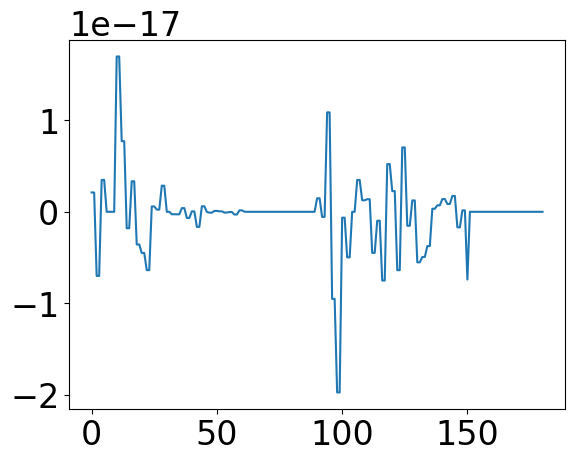

In [44]:
plt.plot(solver.eigenvalues)

In [ ]:
# eval = 5
# print(f"λ = {evals[eval]}")
for eval in range(0, 181, 20):
    solver.set_state(np.argmin(np.abs(solver.eigenvalues - evals[eval])), sp.subsystems[0])

    plt.figure()
    plt.contourf(T['g'].T.real, cmap='coolwarm')
    plt.colorbar()

# Run 

In [6]:
# Make snapshots folder
if not os.path.exists("./modified_spherical_shallow_water_equations"):
    os.mkdir("./modified_spherical_shallow_water_equations")
    os.mkdir(f"./modified_spherical_shallow_water_equations/{experiment_name}")

experiment_name = 'sigma_y_test'

# Analysis
snapshots = solver.evaluator.add_file_handler(
    f"modified_spherical_shallow_water_equations/{experiment_name}",
    sim_dt=downsample_interval,
    max_writes = max_writes
)
snapshots.add_tasks(solver.state)


start_time = time.time()

# Main loop
try:
    logger.info('Starting main loop...')
    logger.info(
        f"{'Iteration':^{2*len(str(total_iterations))+1}} {'%':>7} {'Time (hr)':>{2*len(str(simulation_length//3600))+7}}  {'Timestep (s)':>{12}}"
    )
    while solver.proceed:
        solver.step(timestep)
        # if (solver.iteration) % int(round_out(total_iterations, 'hundreds')/num_logs) == 0:
        if (solver.iteration == 1) or (round(solver.sim_time, 1) % log_interval == 0.0):
            iter_string = f"{solver.iteration:>{len(str(total_iterations))}.0f}/{total_iterations:0.0f}" 
            percent_string = f"{100*solver.iteration/total_iterations:>.1f}"
            time_string = f"{solver.sim_time/3600:>{len(str(simulation_length//3600))}.0f}/{simulation_length/3600:.0f}"
            timestep_string = f"{timestep:>{len(f'{timestep:0.1f}')}.1f}"

            logger.info(f"{iter_string} {percent_string:>7}     {time_string}      {timestep_string}")
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

end_time = time.time()
print(f"Wall time : {(end_time - start_time)/60:0.2f} minutes")

2024-03-05 15:44:05,554 __main__ 0/1 INFO :: Starting main loop...
2024-03-05 15:44:05,555 __main__ 0/1 INFO ::  Iteration        %       Time (hr)  Timestep (s)
2024-03-05 15:44:08,059 __main__ 0/1 INFO ::     1/17280     0.0        0/2880      600.0
2024-03-05 15:44:40,360 __main__ 0/1 INFO ::   864/17280     5.0      144/2880      600.0
2024-03-05 15:45:13,734 __main__ 0/1 INFO ::  1728/17280    10.0      288/2880      600.0
2024-03-05 15:45:47,231 __main__ 0/1 INFO ::  2592/17280    15.0      432/2880      600.0
2024-03-05 15:46:21,438 __main__ 0/1 INFO ::  3456/17280    20.0      576/2880      600.0
2024-03-05 15:46:54,721 __main__ 0/1 INFO ::  4320/17280    25.0      720/2880      600.0
2024-03-05 15:47:28,607 __main__ 0/1 INFO ::  5184/17280    30.0      864/2880      600.0
2024-03-05 15:48:03,274 __main__ 0/1 INFO ::  6048/17280    35.0     1008/2880      600.0
2024-03-05 15:48:39,401 __main__ 0/1 INFO ::  6912/17280    40.0     1152/2880      600.0
2024-03-05 15:49:16,610 __ma

# Analyze data

## Load output data

In [7]:
print(f"Experiment: {experiment_name}")
print("Loading output data...")

output_data_files = glob(f"modified_spherical_shallow_water_equations/{experiment_name}/{experiment_name}_s*.h5")
temperature_list = []
moisture_list = []
velocity_list = []
for data_file in output_data_files: 
    print(f"---- {data_file}")
    temperature_list.append(d3.load_tasks_to_xarray(data_file)['T'])
    moisture_list.append(d3.load_tasks_to_xarray(data_file)['q'])
    velocity_list.append(d3.load_tasks_to_xarray(data_file)['u'])

output_temperature = xr.concat(temperature_list, dim='t')
output_moisture = xr.concat(moisture_list, dim='t')
output_velocity = xr.concat(velocity_list, dim='t')
print("Output data loaded")

time_points = output_temperature.t

Experiment: sigma_y_test
Loading output data...
---- modified_spherical_shallow_water_equations/sigma_y_test/sigma_y_test_s1.h5
---- modified_spherical_shallow_water_equations/sigma_y_test/sigma_y_test_s2.h5
Output data loaded


## 3D Plots

### Define spherical coordinate vertices

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def build_s2_coord_vertices(phi, theta):
    phi = phi.ravel()
    phi_vert = np.concatenate([phi, [2*np.pi]])
    phi_vert -= phi_vert[1] / 2
    theta = theta.ravel()
    theta_mid = (theta[:-1] + theta[1:]) / 2
    theta_vert = np.concatenate([[np.pi], theta_mid, [0]])
    return np.meshgrid(phi_vert, theta_vert, indexing='ij')

### Animate in 3D

In [ ]:
phi = output_moisture.phi.values
theta = output_moisture.theta.values
phi_vert, theta_vert = build_s2_coord_vertices(phi, theta)
x = np.sin(theta_vert) * np.cos(phi_vert)
y = np.sin(theta_vert) * np.sin(phi_vert)
z = np.cos(theta_vert)


fig = plt.figure(figsize=(9,9))
ax = fig.add_axes([0, 0, 1, 1], projection='3d')

def update(t):
    ax.clear()
    
    clim = np.max(np.abs(output_moisture.isel(t=t).values))
    norm = mcolors.Normalize(-clim, clim)
    fc = cmap(norm(output_moisture.isel(t=t).values))
    
    surf = ax.plot_surface(x, y, z, facecolors=fc, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
    ax.set_box_aspect((1,1,1))
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_zlim(-0.7, 0.7)
    ax.axis('off')

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(0, 360, 6), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=30
)

anim.save(f"spherical_shallow_water_equations/{experiment_name}_global_plots.mp4", dpi=200)

## 2D Plots

### Single timestep

#### Natural coordinates

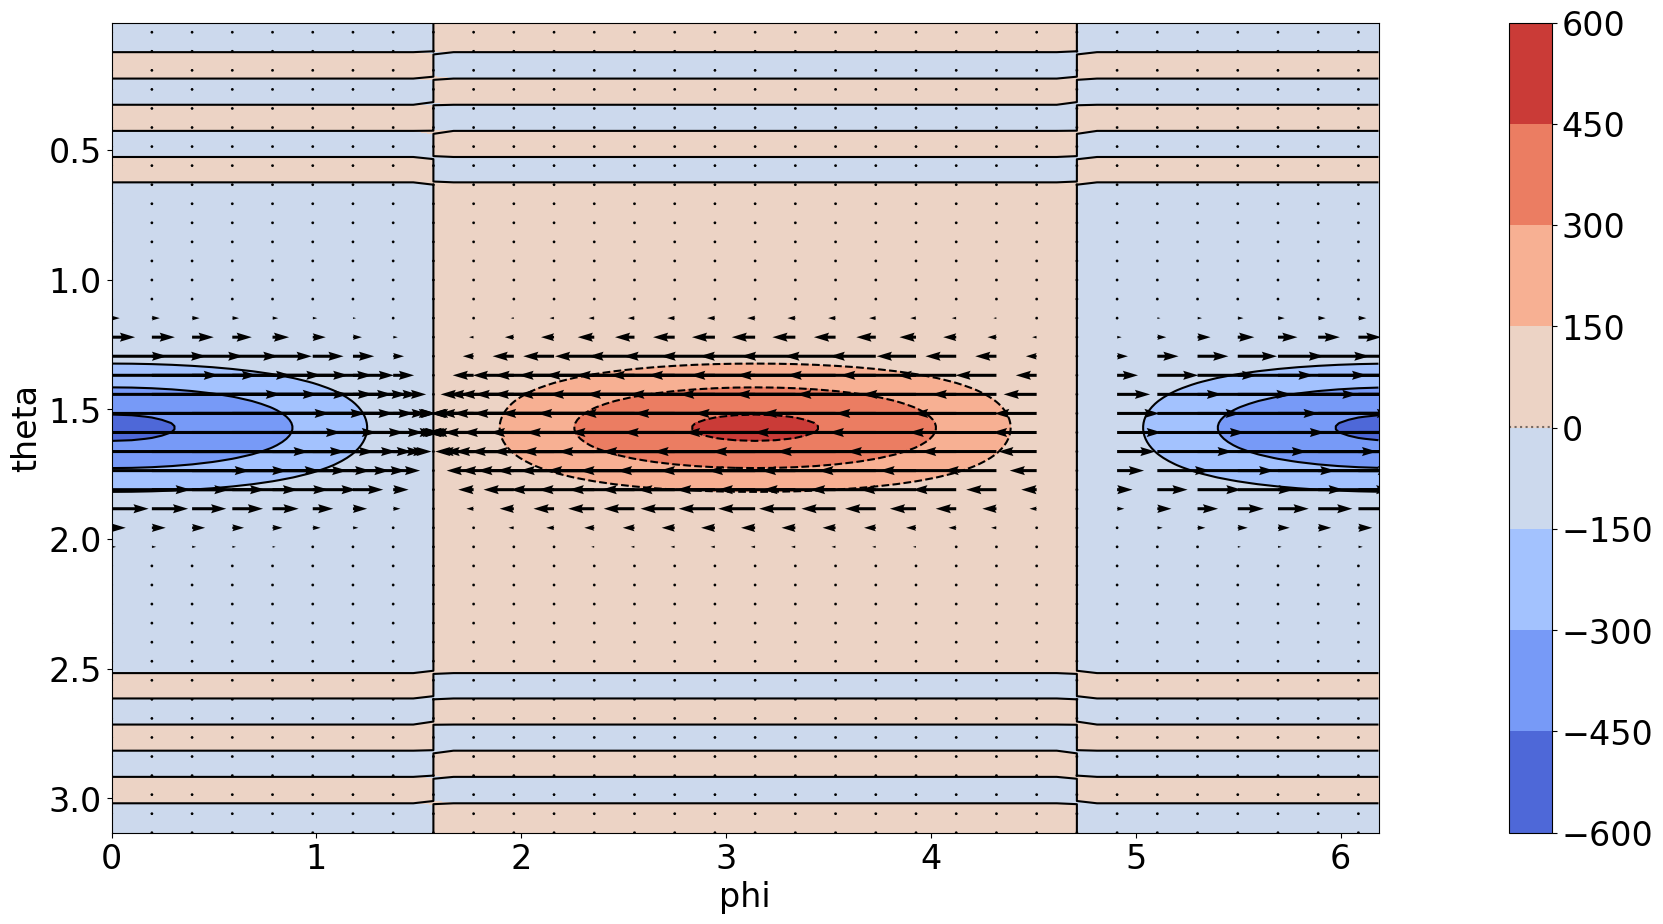

In [8]:
t = 0

# Create dedalus field objects for each of the variables
output_temperature_field = dist.Field(name='output_temperature', bases=basis)
output_moisture_field = dist.Field(name='output_moisture', bases=basis)
output_zonal_velocity_field = dist.Field(name='output_zonal_velocity', bases=basis)
output_meridional_velocity_field = dist.Field(name='output_meridional_velocity', bases=basis)

# Set the grid of the field objects to the value of the output array
output_temperature_field['g'] = output_temperature.isel(t=t)
output_moisture_field['g'] = output_moisture.isel(t=t)
output_zonal_velocity_field['g'] = output_velocity.isel(t=t)[0]
output_meridional_velocity_field['g'] = output_velocity.isel(t=t)[1]

# Scale the fields according to the upscale factor
upscaling_factor = 8
output_temperature_field.change_scales(upscaling_factor)
output_moisture_field.change_scales(upscaling_factor)
output_zonal_velocity_field.change_scales(upscaling_factor)
output_meridional_velocity_field.change_scales(upscaling_factor)
[output_phi, output_theta] = dist.local_grids(basis, scales=upscaling_factor)


fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

CS = ax.contour(
    output_phi.squeeze(),
    output_theta.squeeze(),
    output_temperature_field['g'].T,
    colors = 'k',
    norm=mcolors.CenteredNorm(vcenter=0),
)

CF = ax.contourf(
    output_phi.squeeze(),
    output_theta.squeeze(),
    output_moisture_field['g'].T,
    cmap='coolwarm', 
    norm=mcolors.CenteredNorm(vcenter=0),
)
fig.colorbar(CF, cax=cbar_ax)

phi_quiver_spacing = 2
theta_quiver_spacing = 6

ax.quiver(
    output_phi.squeeze()[::phi_quiver_spacing],
    output_theta.squeeze()[::theta_quiver_spacing],
    output_zonal_velocity_field['g'][::phi_quiver_spacing, ::theta_quiver_spacing].T, 
    output_meridional_velocity_field['g'][::phi_quiver_spacing, ::theta_quiver_spacing].T, 
)
plt.axhline(y=np.pi/2, ls=':', color='k', alpha=0.5)

ax.invert_yaxis()
ax.set_xlabel('phi')
ax.set_ylabel('theta')
ax.set_aspect('auto')
plt.show()

#### Lat/Lon coordinates

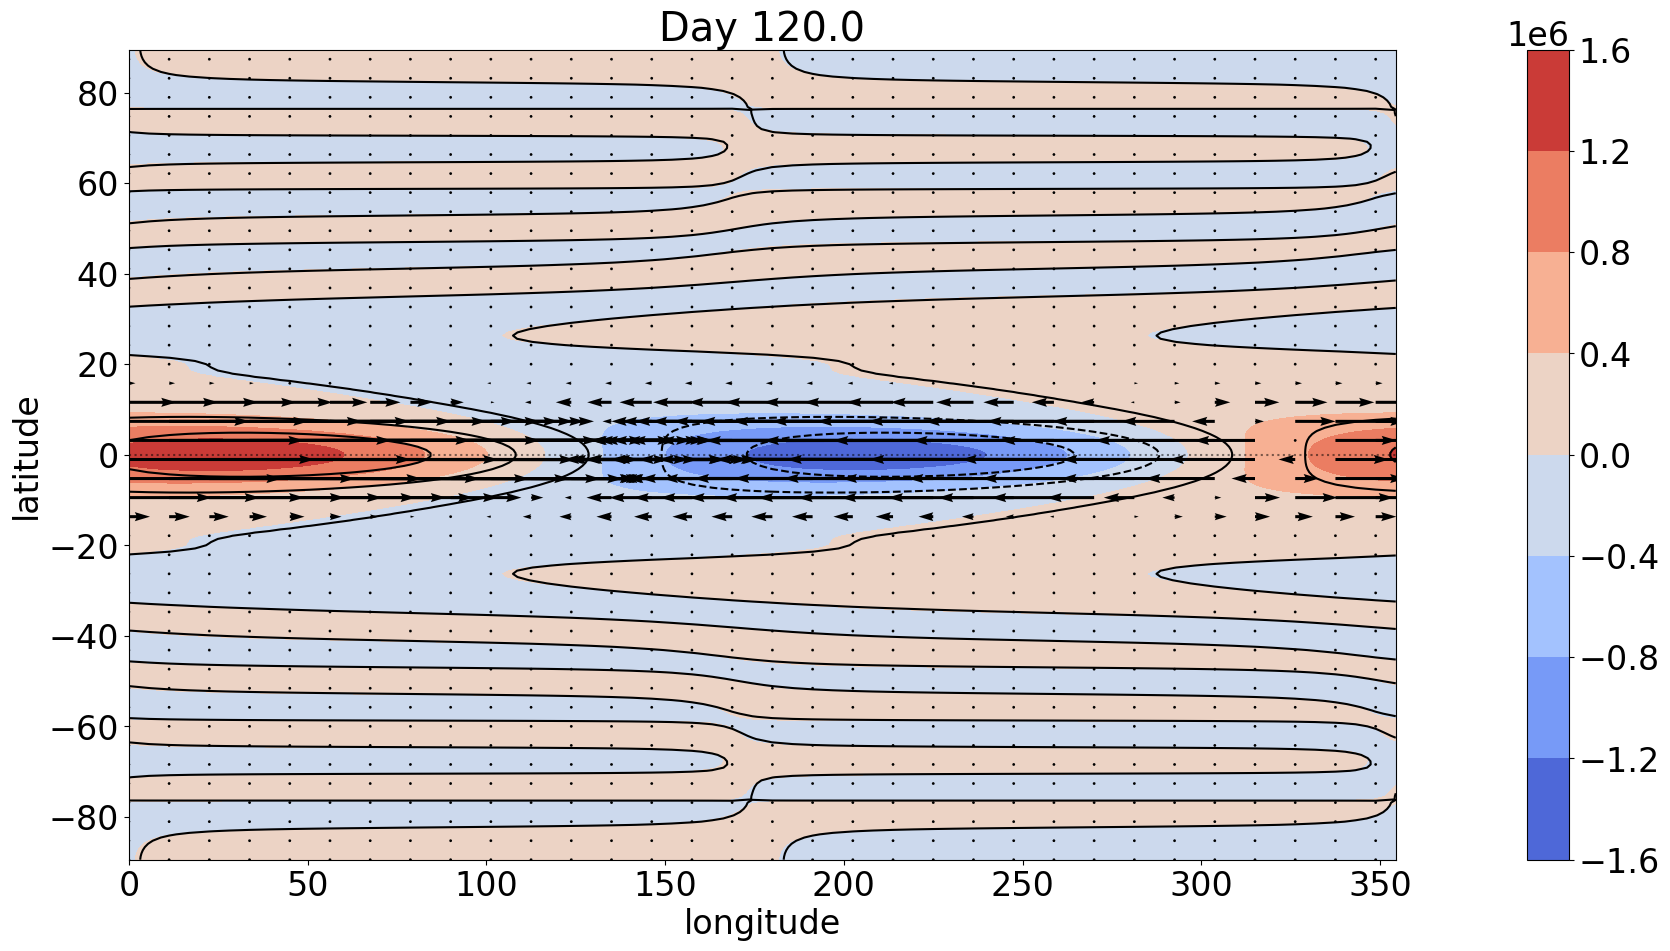

In [10]:
t = -1

# Create dedalus field objects for each of the variables
output_temperature_field = dist.Field(name='output_temperature', bases=basis)
output_moisture_field = dist.Field(name='output_moisture', bases=basis)
output_zonal_velocity_field = dist.Field(name='output_zonal_velocity', bases=basis)
output_meridional_velocity_field = dist.Field(name='output_meridional_velocity', bases=basis)

# Set the grid of the field objects to the value of the output array
output_temperature_field['g'] = output_temperature.isel(t=t)
output_moisture_field['g'] = output_moisture.isel(t=t)
output_zonal_velocity_field['g'] = output_velocity.isel(t=t)[0]
output_meridional_velocity_field['g'] = output_velocity.isel(t=t)[1]

# Scale the fields according to the upscale factor
upscaling_factor = 8
output_temperature_field.change_scales(upscaling_factor)
output_moisture_field.change_scales(upscaling_factor)
output_zonal_velocity_field.change_scales(upscaling_factor)
output_meridional_velocity_field.change_scales(upscaling_factor)
[output_phi, output_theta] = dist.local_grids(basis, scales=upscaling_factor)

# Create latitude and longitude grids
latitude = ((np.pi / 2 - output_theta)*(180/np.pi)).squeeze()
longitude = (output_phi*(180/np.pi)).squeeze()

plt.style.use('default')
plt.rcParams.update({'font.size' : 24})
fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Day {time_points.isel(t=t).values/(24*3600):0.1f}")

CS = ax.contour(
    longitude,
    latitude,
    output_temperature_field['g'].T,
    colors = 'k',
    norm=mcolors.CenteredNorm(vcenter=0),
)

CF = ax.contourf(
    longitude,
    latitude,
    output_moisture_field['g'].T,
    cmap='coolwarm', 
    norm=mcolors.CenteredNorm(vcenter=0),
)
fig.colorbar(CF, cax=cbar_ax)


lon_spacing = 2
lat_spacing = 6
ax.quiver(
    longitude[::lon_spacing],
    latitude[::lat_spacing],
    output_zonal_velocity_field['g'].T[::lat_spacing, ::lon_spacing], 
    output_meridional_velocity_field['g'].T[::lat_spacing, ::lon_spacing], 
    # scale = 1000
)
ax.axhline(y=0, ls=':', color='k', alpha=0.5)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
# ax.set_ylim(-30,30)
ax.set_aspect('auto')
plt.show()

### Animation

In [ ]:
starting_frame = 0
ending_frame = 360
frame_interval = 5

latitude = ((np.pi / 2 - theta)*(180/np.pi)).squeeze()
longitude = (phi*(180/np.pi)).squeeze()

temperature_grand_max = np.max(output_temperature.values)
temperature_grand_min = np.min(output_temperature.values)
temperature_levels = np.linspace(temperature_grand_min, temperature_grand_max, 15)

moisture_grand_max = np.max(output_moisture.values)
moisture_grand_min = np.min(output_moisture.values)
moisture_levels = np.linspace(moisture_grand_min, moisture_grand_max, 15)

proj = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

def update(t):
    ax.clear()
    cbar_ax.clear()
    
    CS = ax.contour(
        longitude,
        latitude,
        output_temperature.T.isel(t=t),
        colors = 'k',
        norm=mcolors.CenteredNorm(vcenter=0),
        levels = temperature_levels,
    )

    CF = ax.contourf(
        longitude,
        latitude,
        # output_height.isel(t=t), 
        output_moisture.T.isel(t=t),
        cmap='coolwarm', 
        levels = moisture_levels,
        norm=mcolors.CenteredNorm(vcenter=0),
    )
    fig.colorbar(CF, cax=cbar_ax)
    
    ax.quiver(
        longitude[::6],
        latitude[::3],
        output_velocity.isel(t=t).values[0].T[::3, ::6], 
        output_velocity.isel(t=t).values[1].T[::3, ::6], 
        scale = 1000
    )
    ax.axhline(y=0, ls=':', color='k', alpha=0.5)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_aspect('auto')

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=60
)

anim.save(f"modified_spherical_shallow_water_equations/{experiment_name}_global_plots_projected.mp4", dpi=200)